<a href="https://colab.research.google.com/github/radonys/Dog-Breed-Classification/blob/master/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dog Breed Identification

Kaggle Challenge link: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification)

### Installing required modules

In [0]:
!pip install tensorboardX
!pip install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision
!pip install numpy
!pip install matplotlib
!pip install kaggle
!pip install pillow==4.0.0

### Imports

In [0]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter
import csv
import zipfile
import shutil
from PIL import Image
import torch.nn.functional as F


In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.1


### Dataset download

Kaggle API is used to download the dataset. To use Kaggle API, we need to have a ***kaggle.json*** file which contains the **username** and the **API key**. To obtain the **json file**, follow the instructions provided  in the link: [Kaggle API GitHub](https://github.com/Kaggle/kaggle-api)

The program asks to upload the ***kaggle.json*** file during execution.

In [0]:
!mkdir -p ~/.kaggle
from google.colab import files
print('Upload the kaggle.json file now')
files.upload()
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c dog-breed-identification
!mkdir all/
!mv *.zip all/
!ls all/
!unzip all/labels.csv 
!unzip all/sample_submission.csv
!mv *.csv all/
!rm all/labels.csv.zip all/sample_submission.csv.zip
!rm kaggle.json

### Dataset Seperation according to labels

In [0]:
labels = set()
if os.path.exists('all/'):

	with open('all/labels.csv', mode='r') as csv_file:

		csv_reader = csv.DictReader(csv_file)
		line_count = 0
		directory = 'all/train_images/'

		if not os.path.exists(directory):
			os.makedirs(directory)


		for row in csv_reader:

			if line_count == 0:

				print('Column names are', {", ".join(row)})
				line_count += 1

			id_value = str(row["id"])
			breed = str(row["breed"])

			if not os.path.exists(os.path.join(directory, breed)):
				os.makedirs(os.path.join(directory, breed))

			traindir = 'all/train/'

			if not os.path.exists(traindir):

				zip_ref = zipfile.ZipFile('all/train.zip', 'r')
				zip_ref.extractall('all/')
				zip_ref.close()

			prev_dir = str(os.path.join(traindir, id_value + '.jpg'))
			new_dir = str(os.path.join(directory, breed, id_value + '.jpg'))
				
			if os.path.exists(os.path.join(traindir, id_value + '.jpg')):
				shutil.move(prev_dir, new_dir)

			line_count +=1

		print('Processed lines: ', line_count)
		os.rmdir(traindir)
		os.rename('all/train_images', 'all/train')

else:
	print('Data directory not found.')
  
zip_ref = zipfile.ZipFile('all/test.zip', 'r')
zip_ref.extractall('all/')
zip_ref.close()
labels = sorted(list(labels))

### Variable Declarations

In [0]:
writer = SummaryWriter()
data_dir = "all/"
model_name = "resnet"
num_classes = 120
batch_size = 8
num_epochs = 100
feature_extract = False

### Train and Save Best Model

In [0]:
def save_model(model,filename):

    state = model.state_dict()
    for key in state: state[key] = state[key].clone().cpu()

    if not os.path.exists('all/saved_models/'):
        os.makedirs('all/saved_models')

    torch.save(state, os.path.join('all/saved_models',filename))

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):

    since = time.time()

    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0,num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            writer.add_scalar('data/Training_Accuracy', 100.0*epoch_acc, epoch)
            writer.add_scalar('data/Training_Loss', epoch_loss, epoch)

            # deep copy the model
            if epoch_acc > best_acc:

                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_model(model, '{}_{}.pth'.format('dog-breed-resnet18',epoch))

            train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Training Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history

### Finetuning setting and Initialize ResNet

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [0]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

### Data Augmentation and Loader

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}
print(image_datasets["train"].classes)
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train']}


### Check for GPU availiability

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = model_ft.to(device)
print(model_ft)

### Parameters to train and Optimizer

In [0]:
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

In [0]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

### Load saved model, if any

In [0]:
#Load saved model, if any
#model_ft.load_state_dict(torch.load('all/saved_models/dog-breed-resnet18_24.pth'))

### Loss Function

In [0]:
criterion = nn.CrossEntropyLoss()

### Train Model and Plot Training Graph

Epoch 0/99
----------
train Loss: 3.0198 Acc: 0.2973

Epoch 1/99
----------
train Loss: 1.9860 Acc: 0.4826

Epoch 2/99
----------
train Loss: 1.7956 Acc: 0.5247

Epoch 3/99
----------
train Loss: 1.7126 Acc: 0.5434

Epoch 4/99
----------
train Loss: 1.6374 Acc: 0.5603

Epoch 5/99
----------
train Loss: 1.5708 Acc: 0.5814

Epoch 6/99
----------
train Loss: 1.4731 Acc: 0.5983

Epoch 7/99
----------
train Loss: 1.4654 Acc: 0.5989

Epoch 8/99
----------
train Loss: 1.4118 Acc: 0.6198

Epoch 9/99
----------
train Loss: 1.3843 Acc: 0.6271

Epoch 10/99
----------
train Loss: 1.3316 Acc: 0.6406

Epoch 11/99
----------
train Loss: 1.3165 Acc: 0.6428

Epoch 12/99
----------
train Loss: 1.2674 Acc: 0.6614

Epoch 13/99
----------
train Loss: 1.2503 Acc: 0.6625

Epoch 14/99
----------
train Loss: 1.2462 Acc: 0.6596

Epoch 15/99
----------
train Loss: 1.1896 Acc: 0.6779

Epoch 16/99
----------
train Loss: 1.1580 Acc: 0.6850

Epoch 17/99
----------
train Loss: 1.1442 Acc: 0.6934

Epoch 18/99
--------

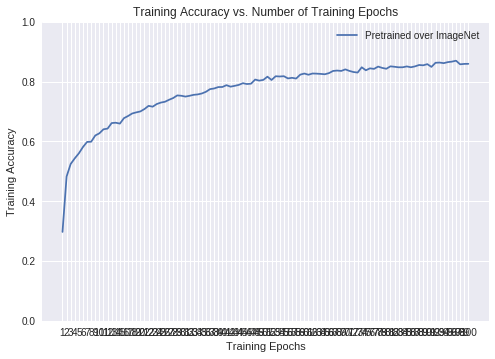

In [19]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained over ImageNet")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.savefig('train-vs-epoch.png')

### Save Training Accuracies for Comparison

In [0]:
with open('training_accuracies.txt', 'w') as filehandle:  
    filehandle.writelines("%s\n" % value for value in ohist)

### Generate CSV file for Kaggle evaluation

In [0]:
test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model_ft.eval()

with open('submission_file.csv', mode='w') as submission_file:
  
  submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  
  headings = ['id'] + image_datasets["train"].classes
  submission_writer.writerow(headings)

  onlyfiles = [f for f in os.listdir('all/test/') if os.path.isfile(os.path.join('all/test/', f))]
  
  for i in range(0,len(onlyfiles)):
    
    input_image = test(Image.open('all/test/' + onlyfiles[i])).unsqueeze(0)
    input_image = input_image.to(device)

    output = model_ft(input_image)
    output = F.softmax(output, dim=1)
    output = output.squeeze().detach().cpu().numpy()
    output = [str(i) for i in output]
    
    file_str = str(onlyfiles[i])
    temp = file_str.split('.')
    row = [temp[0]] + output
    submission_writer.writerow(row)